# Experiment Here!

In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import madmom
import librosa
import mir_eval

In [2]:
FPS = 100

In [3]:
from madmom.utils import search_files, match_file

AUDIO_FILES = search_files('data/train', '.flac')

def find_audio_files(ann_files, audio_files, ann_suffix=None, audio_suffix='.wav'):
    """
    Find matching audio files.
    
    Parameters
    ----------
    ann_files : list
        List with annotation file names.
    audio_files : list
        List with audio file names to be matched
    ann_suffix : str, optional
        Suffix of the annotation files. If 'None'
        the suffix is inferred from the annotation
        files.
    audio_suffix : str, optional
        Suffix of the audio files.
    
    Returns
    -------
    matched_files : list
        List of matched audio file (names).
    matched_indices : list
        List of matching indices in `audio_files`.
        
    """
    matched_files = []
    matched_indices = []
    for i, ann_file in enumerate(ann_files):
        if ann_suffix is None:
            ann_suffix = os.path.splitext(ann_file)[1]
        matches = match_file(ann_file, audio_files,
                             ann_suffix, audio_suffix)
        if len(matches) == 1:
            matched_files.append(matches[0])
            matched_indices.append(i)
        else:
            continue
    return matched_files, matched_indices

In [4]:
# len(AUDIO_FILES)

In [5]:
# from scripts import utilities
# utilities.main()

# Pre-Processing

In [6]:
import math
import numpy as np

# define constants
SR = 44100 # samping rate
FRAME_SIZE = 2048 # number of samples per frame
HOP_SIZE = int(SR / FPS) # hop size depends on sampling rate and frame rate
NUM_BANDS = 40 # number of mel bins

def pre_process(filename, frame_size=2048, frame_rate=FPS, num_bands=40, **kwargs):
    """
    Pre-process the audio signal.

    Parameters
    ----------
    filename : str
        File to be processed.
    frame_size : int
        Size of the frames.
    frame_rate : float
        Frame rate used for the STFT.
    num_bands : int
        Number of frequency bands for the Mel filterbank.
    kwargs : dict, optional
        Additional keyword arguments.

    Returns
    -------
    spectrogram : numpy array
        Spectrogram.

    """    
    # STEP 1: read in audio
    signal, sr = librosa.load(filename, sr=SR) # read file
    
    # STEP 2,3: compute stft (default windowing function is Hann)
    stft = librosa.core.stft(y=signal, n_fft=frame_size, hop_length=HOP_SIZE)
    
    # STEP 4: discard phase info and square magnitudes
    initial_spectrogram = abs(stft)**2
    
    # STEP 5: apply mel scaling
    mel_bins = librosa.filters.mel(sr=SR, n_fft=frame_size, n_mels=num_bands)
    mel_spectrogram = mel_bins.dot(initial_spectrogram)
    
    # STEP 6: apply DB scaling
    db_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    # double check
    # mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=frame_size, hop_length=hop_size, n_mels=num_bands)
    # db_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    # print((db_mel_spectrogram)[0])
        
    spectrogram = db_mel_spectrogram
    return spectrogram

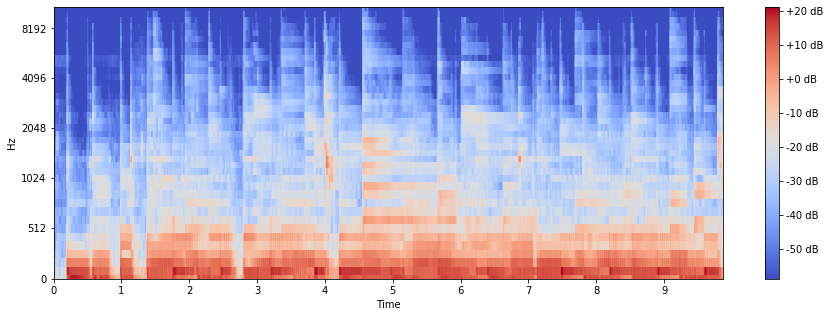

In [7]:
from librosa.display import specshow

texasName = AUDIO_FILES[19] #AUDIO_FILES[19]

spectrogram = pre_process(texasName, FRAME_SIZE, FPS, NUM_BANDS)

# print(spectrogram.shape)

plt.figure(figsize=(15, 5))
specshow(spectrogram, sr=SR, hop_length=HOP_SIZE, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
